In [ ]:
#|default_exp text.modeling.seq2seq.translation
#|default_cls_lvl 3

In [ ]:
#| nbflags skip_exec


In [ ]:
#|hide
%reload_ext autoreload
%autoreload 2

# Modeling

> The `text.modeling.seq2seq.translation` module contains custom models, custom splitters, etc... translation tasks.

In [ ]:
#|export
import inspect, torch, warnings
from typing import Callable, Dict, List, Optional, Union

from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoaders
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from fastcore.all import *
from transformers import AutoModelForSeq2SeqLM, PreTrainedModel
from transformers.utils import logging as hf_logging

from blurr.text.data.seq2seq.core import Seq2SeqBatchTokenizeTransform, Seq2SeqTextBlock, default_text_gen_kwargs
from blurr.text.modeling.core import BaseModelCallback, BaseModelWrapper, Blearner
from blurr.text.modeling.seq2seq.core import Seq2SeqMetricsCallback, blurr_seq2seq_splitter
from blurr.text.utils import get_hf_objects
from blurr.utils import PreCalculatedCrossEntropyLoss


In [ ]:
#| hide
import ast, os, inspect, pdb
from functools import reduce

from datasets import load_dataset
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger, OptimWrapper, params
from fastcore.test import *
from nbdev import nbdev_export
from nbdev.showdoc import show_doc

from blurr.utils import print_versions
from blurr.text.utils import BlurrText


What we're running with at the time this documentation was generated:
torch: 1.10.1+cu111
fastai: 2.6.3
transformers: 4.18.0


In [ ]:
# |export
# silence all the HF warnings
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()

In [ ]:
# | echo: false
NLP = BlurrText()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")


In [ ]:
#|hide
#|cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #1: GeForce GTX 1080 Ti


## Mid-level API

### Prepare the data

### Example

The objective in translation is to generate a representation of a given text in another style. For example, we may want to translate German into English or modern English into old English.

In [ ]:
dataset = load_dataset("wmt16", "de-en", split="train")
dataset = dataset.shuffle(seed=32).select(range(1200))
wmt_df = pd.DataFrame(dataset["translation"], columns=["de", "en"])
len(wmt_df)
wmt_df.head(2)


Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.73k [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/658M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/919M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/75.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/38.7M [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0 examples [00:00, ? examples/s]

Generating examples from: %s europarl_v7
Generating examples from: %s commoncrawl
Generating examples from: %s newscommentary_v11


0 examples [00:00, ? examples/s]

Generating examples from: %s newstest2015


0 examples [00:00, ? examples/s]

Generating examples from: %s newstest2016
Dataset wmt16 downloaded and prepared to /home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/af3c5d746b307726d0de73ebe7f10545361b9cb6f75c83a1734c000e48b6264f. Subsequent calls will reuse this data.


,de,en
0,"Tada se dio stanovništva preselio uz samu obalu - Pristan, gdje je i nastao Novi grad početkom XX vijeka.","In that period the majority of the population moved close to the seaside, where the first sea port was founded at the beginning of the 20th century, and later a new city was built."
1,"""Dieses Video ist nicht verfügbar loger"" bitch, daß das Böse, der sein Video auf YouTube hochgeladen hatte nearsyx?","""This video is no loger available"" that evil bitch, who had uploaded his video on youtube nearsyx?"


In [ ]:
pretrained_model_name = "Helsinki-NLP/opus-mt-de-en"
model_cls = AutoModelForSeq2SeqLM

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls)
hf_arch, type(hf_tokenizer), type(hf_config), type(hf_model)


https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/wgilliam/.cache/huggingface/transformers/tmppp9i08el


Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

storing https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/config.json in cache at /home/wgilliam/.cache/huggingface/transformers/1854c5c3f3aeab11cfc4ef9f74e960e7bf2300332cd7cdbd83077f02499cdfab.b1412cdfcd82522fbf1b1559d2bb133e7c34f871e99859d46b74f1533daa4757
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/1854c5c3f3aeab11cfc4ef9f74e960e7bf2300332cd7cdbd83077f02499cdfab.b1412cdfcd82522fbf1b1559d2bb133e7c34f871e99859d46b74f1533daa4757
loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/config.json from cache at /home/wgilliam/.cache/huggingface/transformers/1854c5c3f3aeab11cfc4ef9f74e960e7bf2300332cd7cdbd83077f02499cdfab.b1412cdfcd82522fbf1b1559d2bb133e7c34f871e99859d46b74f1533daa4757
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-de-en",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "archite

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

storing https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/tokenizer_config.json in cache at /home/wgilliam/.cache/huggingface/transformers/3bb44a3386cfbb9cb18134066610daf2447a07f2f56a14bed4ef1ffee714851c.ab636688faaa6513d9a830ea57bdb7081f0dda90f9de5e3c857a239f0cc406e7
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/3bb44a3386cfbb9cb18134066610daf2447a07f2f56a14bed4ef1ffee714851c.ab636688faaa6513d9a830ea57bdb7081f0dda90f9de5e3c857a239f0cc406e7
loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/config.json from cache at /home/wgilliam/.cache/huggingface/transformers/1854c5c3f3aeab11cfc4ef9f74e960e7bf2300332cd7cdbd83077f02499cdfab.b1412cdfcd82522fbf1b1559d2bb133e7c34f871e99859d46b74f1533daa4757
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-de-en",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,


Downloading:   0%|          | 0.00/778k [00:00<?, ?B/s]

storing https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/source.spm in cache at /home/wgilliam/.cache/huggingface/transformers/97f9ac1f9bf6b0e421cdf322cd4243cf20650839545200bf6b513ad03c168c8c.7bc2908774e59068751778d82930d24fe5b81375f4e06aa8f2a62298103c9587
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/97f9ac1f9bf6b0e421cdf322cd4243cf20650839545200bf6b513ad03c168c8c.7bc2908774e59068751778d82930d24fe5b81375f4e06aa8f2a62298103c9587
https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/target.spm not found in cache or force_download set to True, downloading to /home/wgilliam/.cache/huggingface/transformers/tmp_780e_84


Downloading:   0%|          | 0.00/750k [00:00<?, ?B/s]

storing https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/target.spm in cache at /home/wgilliam/.cache/huggingface/transformers/1c5dd1c09c6117b6da35a0bfc70dee4e4852bd9f1e019474ccd80f98014806b5.5ff349d0044d463eca29fbb3a3d21a2dd0511ced746d6c6941daa893faf53d79
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/1c5dd1c09c6117b6da35a0bfc70dee4e4852bd9f1e019474ccd80f98014806b5.5ff349d0044d463eca29fbb3a3d21a2dd0511ced746d6c6941daa893faf53d79
https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/vocab.json not found in cache or force_download set to True, downloading to /home/wgilliam/.cache/huggingface/transformers/tmp9veehttl


Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

storing https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/vocab.json in cache at /home/wgilliam/.cache/huggingface/transformers/135ba2ed81322da617731039edec94c1b10b121b5499ea1bcdd7e60040cf4913.fe9bdbcb654d47ed6918ebaad81166b879fd0bc12ea76a2cc54359202fa854d7
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/135ba2ed81322da617731039edec94c1b10b121b5499ea1bcdd7e60040cf4913.fe9bdbcb654d47ed6918ebaad81166b879fd0bc12ea76a2cc54359202fa854d7
loading file https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/source.spm from cache at /home/wgilliam/.cache/huggingface/transformers/97f9ac1f9bf6b0e421cdf322cd4243cf20650839545200bf6b513ad03c168c8c.7bc2908774e59068751778d82930d24fe5b81375f4e06aa8f2a62298103c9587
loading file https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/target.spm from cache at /home/wgilliam/.cache/huggingface/transformers/1c5dd1c09c6117b6da35a0bfc70dee4e4852bd9f1e019474ccd80f98014806b5.5ff349d0044d463eca29fbb3a3d21a2dd0

Downloading:   0%|          | 0.00/284M [00:00<?, ?B/s]

storing https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/pytorch_model.bin in cache at /home/wgilliam/.cache/huggingface/transformers/939fa8e38fdeb206b841054406fe90638dbe4a602679798fc35126e90fe54e12.9f2385d4ebdde4e5e8ef144654a4666f40c8423a85f51590fecb88452aec1514
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/939fa8e38fdeb206b841054406fe90638dbe4a602679798fc35126e90fe54e12.9f2385d4ebdde4e5e8ef144654a4666f40c8423a85f51590fecb88452aec1514
loading weights file https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/pytorch_model.bin from cache at /home/wgilliam/.cache/huggingface/transformers/939fa8e38fdeb206b841054406fe90638dbe4a602679798fc35126e90fe54e12.9f2385d4ebdde4e5e8ef144654a4666f40c8423a85f51590fecb88452aec1514
All model checkpoint weights were used when initializing MarianMTModel.

All the weights of MarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-de-en.
If your task is similar to the task the model

('marian',
 transformers.models.marian.tokenization_marian.MarianTokenizer,
 transformers.models.marian.configuration_marian.MarianConfig,
 transformers.models.marian.modeling_marian.MarianMTModel)

In [ ]:
blocks = (Seq2SeqTextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader("de"), get_y=ColReader("en"), splitter=RandomSplitter())


In [ ]:
dls = dblock.dataloaders(wmt_df, bs=2)


In [ ]:
b = dls.one_batch()


In [ ]:
len(b), b[0]["input_ids"].shape, b[1].shape


(2, torch.Size([2, 168]), torch.Size([2, 140]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, input_trunc_at=250, target_trunc_at=250)


,text,target
0,"""In▁Erwägung▁nachstehender▁Gründe▁sollte das▁Europäische▁Parlament▁keinerlei▁Doppelmoral tolerieren. Indessen und um▁politischen Druck auf▁Journalisten▁auszuüben, die▁Korruptionsfälle aufdecken, die in▁Verbindung mit▁hochrangigen▁Beamten und▁regieren","'whereas the European Parliament shall not accept double standards; whereas, in order to put political pressure on journalists disclosing corruption cases linked to high-ranking officials and ruling party politicians, the Government administration in"
1,"Es▁ist▁jetzt▁wirklich an der Zeit,▁daß nicht▁nur in▁bezug auf den▁Jahreswirtschaftsbericht und die▁wirtschaftspolitischen▁Leitlinien,▁nein,▁auch in▁bezug auf die▁gesamten▁Fragen zum▁Verfahren zur▁Feststellung des▁übermäßigen▁Defizits und▁auch in▁bezu",It really is time for the European Parliament to be given a codecision right that is consistent with the further democratic development of this European Union; that right must apply not just to the annual economic report and the economic policy guide


#### Training

In [ ]:
seq2seq_metrics = {"bleu": {"returns": "bleu"}, "meteor": {"returns": "meteor"}, "sacrebleu": {"returns": "score"}}

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat()
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# learn = learn.to_native_fp16() #.to_fp16()
learn.freeze()


Downloading:   0%|          | 0.00/2.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wgilliam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wgilliam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

In [ ]:
#| output: false
learn.summary()


BaseModelWrapper (Input shape: 2 x 168)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 140 x 512       
Embedding                                 29747712   False     
Embedding                                 29747712   False     
____________________________________________________________________________
                     2 x 512             
MarianSinusoidalPositionalEmbedding                      262144     False     
Linear                                    262656     False     
Linear                                    262656     False     
Linear                                    262656     False     
Linear                                    262656     False     
LayerNorm                                 1024       True      
SiLUActivation                                                 
____________________________________________________________________________
                     2 x 168 x 2048      
Linear                   

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds), preds["loss"].shape, preds["logits"].shape


(3, torch.Size([]), torch.Size([2, 140, 58101]))

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape


(2, 3, torch.Size([2, 168]), 2, torch.Size([2, 140]))

In [ ]:
print(len(learn.opt.param_groups))


3


SuggestedLRs(minimum=3.981071640737355e-05, steep=6.309573450380412e-07, valley=5.248074739938602e-05, slide=7.585775892948732e-05)

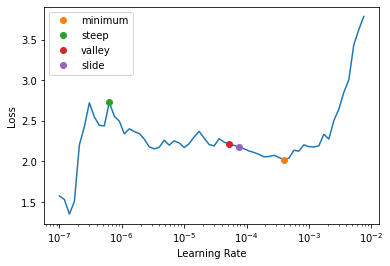

In [ ]:
#|slow
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [ ]:
learn.fit_one_cycle(1, lr_max=4e-5, cbs=fit_cbs)


epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,2.088453,2.097524,0.295524,0.543777,28.882930,00:58


#### Showing results

And here we create a `@typedispatch`ed implementation of `Learner.show_results`.

In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=500)


,text,target,prediction
0,"▁Schließen die▁vorgeschlagenen▁Anwendungszwecke▁Empfehlungen über die▁Bekämpfung von oder den▁Schutz▁gegen▁Organismen ein, die▁unter den in der▁vorgesehenen▁Anwendungsregion▁herrschenden▁Bedingungen in▁bezug auf▁Landwirtschaft,▁Pflanzenschutz und Umwelt -▁einschließlich der▁Witterungsverhältnisse - nach den▁Erfahrungen und dem▁wissenschaftlichen▁Erkenntnisstand nicht▁als▁schädlich▁gelten, oder▁ist▁davon▁auszugehen,▁daß die▁anderen▁Wirkungen▁unter▁diesen▁Bedingungen den▁beabsichtigten▁Zweck nicht","Where relevant, yield response when the product is used and reduction of loss in storage must be quantitatively and/or qualitatively similar to those resulting from the use of suitable reference products. If no suitable reference product exists, the plant protection product must be shown to give a consistent and defined quantitative and/or qualitative benefit in terms of yield response and reduction of loss in storage under the agricultural, plant health and environmental (including climatic) co","[Where the proposed uses include recommendations on the control of or protection against organisms which are not considered to be harmful under the conditions prevailing in the intended application region in respect of agriculture, plant health and the environment, including climatic conditions, in the light of experience and scientific knowledge, or where it is assumed that the other effects do not meet the intended purpose under such conditions, no authorisation shall be granted for such uses., That is why we have listened to you and asked you to introduce a further transparent consultation procedure on the Anti-Counterfeiting Agreement (ACTA) to ensure that the European Parliament and the citizens represented by this Parliament are regularly and comprehensively informed about the progress of the negotiations, while respecting the confidentiality clauses that you have just explained to us about the agreement.]"


#### Prediction

We add here `Learner.blurr_translate` method to bring the results inline with the format returned via Hugging Face's pipeline method

In [ ]:
test_de = "Ich trinke gerne Bier"


In [ ]:
outputs = learn.blurr_generate(test_de, key="translation_texts", num_return_sequences=3)
outputs


[{'translation_texts': ['I like to drink beer',
   'I like to drink beer.',
   'I like drinking beer']}]

In [ ]:
#|export
@patch
def blurr_translate(self: Learner, inp, **kwargs):
    preds = self.blurr_generate(inp, key="translation_texts", **kwargs)
    return preds


In [ ]:
learn.blurr_translate(test_de, num_return_sequences=3)


[{'translation_texts': ['I like to drink beer',
   'I like to drink beer.',
   'I like drinking beer']}]

#### Inference

Using fast.ai `Learner.export` and `load_learner`

In [ ]:
export_fname = "translation_export"


In [ ]:
learn.metrics = None
learn.export(fname=f"{export_fname}.pkl")


In [ ]:
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_de)


[{'translation_texts': 'I like to drink beer'}]

In [ ]:
#|hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


## High-level API

### `BlearnerForTranslation` -

In [ ]:
#|export
@delegates(Blearner.__init__)
class BlearnerForTranslation(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        super().__init__(dls, hf_model, **kwargs)

    def predict(self, text, **kwargs):
        return self.blurr_translate(text, **kwargs)

    @classmethod
    def get_model_cls(cls):
        return AutoModelForSeq2SeqLM

    @classmethod
    def _add_t5_prefix(cls, inp, src_lang_name, trg_lang_name):
        return f"translate {src_lang_name} to {trg_lang_name}: {inp}"

    @classmethod
    def get_metrics_cb(self):
        seq2seq_metrics = {"bleu": {"returns": "bleu"}, "meteor": {"returns": "meteor"}, "sacrebleu": {"returns": "score"}}

        return Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)

    @classmethod
    def from_data(
        cls,
        # Your raw dataset. Supports DataFrames, Hugging Face Datasets, as well as file paths
        # to .csv, .xlsx, .xls, and .jsonl files
        data: Union[pd.DataFrame, Path, str, List[Dict]],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # The language of your source (inputs)
        src_lang_name: str = "English",
        # The attribute/column of your source language texts
        src_lang_attr: str = "src_lang",
        # The attribute/column of your target language texts
        trg_lang_name: str = "English",
        # The attribute/column of your target language texts (this is what you want to predict)
        trg_lang_attr: str = "trg_lang",
        # The max length of your raw text to consider for summarization
        max_length: Union[int, str] = None,
        # The max length of your targets (sumamrized) text
        max_target_length: Union[int, str] = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Optional[Callable] = None,
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs: dict = {},
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs: dict = {},
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs: dict = {},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs: dict = {},
    ):
        # if we get a path/str then we're loading something like a .csv file
        if isinstance(data, Path) or isinstance(data, str):
            content_type = mimetypes.guess_type(data)[0]
            if content_type == "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet":
                data = pd.read_excel(data)
            elif content_type == "text/csv":
                data = pd.read_csv(data)
            elif content_type == "application/json":
                data = pd.read_json(data, orient="records")
            else:
                raise ValueError("'data' must be a .xlsx, .xls, .csv, or .jsonl file")

            data = pd.read_csv(data)

        # infer our datablock splitter if None
        if dblock_splitter is None:
            dblock_splitter = ColSplitter() if hasattr(data, "is_valid") else RandomSplitter()

        # we need to find the architecture to ensure "mbart" specific tokenizer kwargs are included
        model_cls = cls.get_model_cls()
        model = model_cls.from_pretrained(pretrained_model_name_or_path)
        hf_arch = model.__module__.split(".")[2]

        if hf_arch == "mbart":
            hf_tok_kwargs = {**{"src_lang": "en_XX", "tgt_lang": "en_XX"}, **hf_tok_kwargs}

        # get our hf objects
        hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
            pretrained_model_name_or_path, model_cls=model_cls, tokenizer_kwargs=hf_tok_kwargs
        )

        # update text generation kwargs
        text_gen_kwargs = {**text_gen_kwargs, **default_text_gen_kwargs(hf_config, hf_model, task="translation")}

        # not all "translation" parameters are for the model.generate method ... remove them here
        generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
        for k in text_gen_kwargs.copy():
            if k not in generate_func_args:
                del text_gen_kwargs[k]

        # update our text generation kwargs for mbart
        if hf_arch == "mbart":
            text_gen_kwargs = {**{"decoder_start_token_id": "en_XX"}, **text_gen_kwargs}

        # build dblock, dls, and default metrics (optional)
        get_x = Pipeline(funcs=[ColReader(src_lang_attr)])
        get_y = ItemGetter(trg_lang_attr)

        if hf_arch == "t5":
            get_x.add(partial(cls._add_t5_prefix, src_lang_name=src_lang_name, trg_lang_name=trg_lang_name))

        batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
            hf_arch,
            hf_config,
            hf_tokenizer,
            hf_model,
            max_length=max_length,
            max_target_length=max_target_length,
            text_gen_kwargs=text_gen_kwargs,
        )

        blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)
        dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=get_y, splitter=dblock_splitter)

        dls = dblock.dataloaders(data, **dl_kwargs.copy())

        # return BLearner instance
        learner_kwargs["splitter"] = learner_kwargs.pop("splitter", partial(blurr_seq2seq_splitter, arch=hf_arch))
        learner_kwargs["loss_func"] = learner_kwargs.pop("loss_func", PreCalculatedCrossEntropyLoss())
        return cls(dls, hf_model, **learner_kwargs.copy())


In [ ]:
learn = BlearnerForTranslation.from_data(
    wmt_df,
    "Helsinki-NLP/opus-mt-de-en",
    src_lang_name="German",
    src_lang_attr="de",
    trg_lang_name="English",
    trg_lang_attr="en",
    dl_kwargs={"bs": 2},
)


loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/config.json from cache at /home/wgilliam/.cache/huggingface/transformers/1854c5c3f3aeab11cfc4ef9f74e960e7bf2300332cd7cdbd83077f02499cdfab.b1412cdfcd82522fbf1b1559d2bb133e7c34f871e99859d46b74f1533daa4757
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-de-en",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      58100
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 58100,
  "decoder_vocab_size": 58101,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_laye

In [ ]:
metrics_cb = BlearnerForTranslation.get_metrics_cb()
learn.fit_one_cycle(1, lr_max=4e-5, cbs=[metrics_cb])


[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wgilliam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wgilliam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,2.014099,2.172663,0.307334,0.537191,29.823626,00:52


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)


,text,target,prediction
0,"(IT) Herr▁Präsident, Herr▁Kommissar,▁meine▁Damen und Herren, so▁genau▁wie die▁Entschließung mit dem▁Titel ""Naturkatastrophen"", die von der▁Fraktion der▁Europäischen▁Volkspartei (Christdemokraten)▁vorgelegt wurde,▁ist,▁würde▁ich▁gerne▁trotzdem die▁Aufmerksamkeit auf▁einige▁Punkte▁lenken, die▁heute▁Abend▁angesprochen▁wurden, die▁aber nicht in der▁Entschließung zum▁Thema▁gemacht▁werden, und die▁Gegenstand▁meiner▁Änderungsvorschläge▁sind.","(IT) Mr President, Commissioner, ladies and gentlemen, as accurate as the resolution entitled 'Natural disasters', tabled by the Group of the European People's Party (Christian Democrats), is, I would nonetheless like to draw attention to some points","[(IT) Mr President, Commissioner, ladies and gentlemen, just as the resolution on natural disasters presented by the Group of the European People's Party (Christian Democrats), I would like to draw attention to some of the points raised this evening, which are not dealt with in the resolution, and which are the subject of my amendments., This Parliament has always been an example and a champion in the defence of human rights, and at this critical time it must prove that it is not doing a common cause with a corrupt dictator in full decline and that it will allow itself to be carried away by the collaboration of some Members who have always been manipulated by this dictatorship.]"


In [ ]:
test_de = "Ich trinke gerne Bier"


In [ ]:
learn.blurr_translate(test_de)


[{'translation_texts': 'I like to drink beer'}]

In [ ]:
export_fname = "translation_export"

learn.metrics = None
learn = learn.to_fp32()
learn.export(fname=f"{export_fname}.pkl")

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_generate(test_de)


[{'generated_texts': 'I like to drink beer'}]

## Tests

The purpose of the following tests is to ensure as much as possible, that the core training code works for the pretrained **translation models** below.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained summarization models you are working with ... and if any of your pretrained translation models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
try:
    del learn
    torch.cuda.empty_cache()
except:
    pass


In [ ]:
[model_type for model_type in NLP.get_models(task="ConditionalGeneration") if (not model_type.startswith("TF"))]


['BartForConditionalGeneration',
 'BigBirdPegasusForConditionalGeneration',
 'BlenderbotForConditionalGeneration',
 'BlenderbotSmallForConditionalGeneration',
 'FSMTForConditionalGeneration',
 'LEDForConditionalGeneration',
 'M2M100ForConditionalGeneration',
 'MBartForConditionalGeneration',
 'MT5ForConditionalGeneration',
 'PLBartForConditionalGeneration',
 'PegasusForConditionalGeneration',
 'ProphetNetForConditionalGeneration',
 'Speech2TextForConditionalGeneration',
 'T5ForConditionalGeneration',
 'XLMProphetNetForConditionalGeneration']

In [ ]:
pretrained_model_names = [
    "facebook/bart-base",
    "facebook/wmt19-de-en",  # FSMT
    "Helsinki-NLP/opus-mt-de-en",  # MarianMT
    #'sshleifer/tiny-mbart',
    #'google/mt5-small',
    "t5-small",
]


In [ ]:
dataset = load_dataset("wmt16", "de-en", split="train")
dataset = dataset.shuffle(seed=32).select(range(1200))
wmt_df = pd.DataFrame(dataset["translation"], columns=["de", "en"])
len(wmt_df)


Reusing dataset wmt16 (/home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/af3c5d746b307726d0de73ebe7f10545361b9cb6f75c83a1734c000e48b6264f)
Loading cached shuffled indices for dataset at /home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/af3c5d746b307726d0de73ebe7f10545361b9cb6f75c83a1734c000e48b6264f/cache-8fc54b133c8c43b7.arrow


1200

In [ ]:
#|slow
#| output: false
model_cls = AutoModelForSeq2SeqLM
bsz = 2
inp_seq_sz = 128
trg_seq_sz = 128

test_results = []
for model_name in pretrained_model_names:
    error = None

    print(f"=== {model_name} ===\n")

    hf_tok_kwargs = {}
    if model_name == "sshleifer/tiny-mbart":
        hf_tok_kwargs["src_lang"], hf_tok_kwargs["tgt_lang"] = "de_DE", "en_XX"

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, tokenizer_kwargs=hf_tok_kwargs)

    print(f"architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n")

    # 1. build your DataBlock
    text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task="translation")

    def add_t5_prefix(inp):
        return f"translate German to English: {inp}" if (hf_arch == "t5") else inp

    batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
        hf_arch,
        hf_config,
        hf_tokenizer,
        hf_model,
        padding="max_length",
        max_length=inp_seq_sz,
        max_target_length=trg_seq_sz,
        text_gen_kwargs=text_gen_kwargs,
    )

    blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)
    dblock = DataBlock(blocks=blocks, get_x=Pipeline([ColReader("de"), add_t5_prefix]), get_y=ColReader("en"), splitter=RandomSplitter())

    dls = dblock.dataloaders(wmt_df, bs=bsz)
    b = dls.one_batch()

    # 2. build your Learner
    seq2seq_metrics = {}

    model = BaseModelWrapper(hf_model)
    fit_cbs = [ShortEpochCallback(0.05, short_valid=True), Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

    learn = Learner(
        dls,
        model,
        opt_func=ranger,
        loss_func=PreCalculatedCrossEntropyLoss(),
        cbs=[BaseModelCallback],
        splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
    ).to_fp16()

    learn.create_opt()
    learn.freeze()

    # 3. Run your tests
    try:
        print("*** TESTING DataLoaders ***\n")
        test_eq(len(b), 2)
        test_eq(len(b[0]["input_ids"]), bsz)
        test_eq(b[0]["input_ids"].shape, torch.Size([bsz, inp_seq_sz]))
        test_eq(len(b[1]), bsz)

        #         print('*** TESTING One pass through the model ***')
        #         preds = learn.model(b[0])
        #         test_eq(preds[1].shape[0], bsz)
        #         test_eq(preds[1].shape[2], hf_config.vocab_size)

        print("*** TESTING Training/Results ***")
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=fit_cbs)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "PASSED", ""))
        learn.show_results(learner=learn, max_n=2, input_trunc_at=500, target_trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "FAILED", err))
    finally:
        # cleanup
        del learn
        torch.cuda.empty_cache()


=== facebook/bart-base ===



loading configuration file https://huggingface.co/facebook/bart-base/resolve/main/config.json from cache at /home/wgilliam/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.a243ed957122436adb0b8d8e9d20f896f45c174b6324d625ca0a20a84f72a910
Model config BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_t

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Ich habe das Glück hier zu stehen, als schwuler Mann - und wenn ich für mich beschlossen habe, schwul zu sein, ist es nicht interessant, dass jemand anderes offensichtlich für sich bestimmt, heterosexuell zu sein? - Kampf für die Gleichstellung, nicht nur für schwule Männer und Lesben und Bisexuelle und Transgender, sondern","I stand here fortunate, as a gay man - and if I chose to be gay, is it not interesting that one obviously therefore chooses to be heterosexual? - fighting for equality, not just for gay men and lesbians and bisexuals and transgender people, but for","[ Ich habe das Glück hier zu stehen, als sch, schriftlich. - (EL) Der Bericht macht buchstä]"


=== facebook/wmt19-de-en ===



https://huggingface.co/facebook/wmt19-de-en/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/wgilliam/.cache/huggingface/transformers/tmpg94k7zk0


Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

storing https://huggingface.co/facebook/wmt19-de-en/resolve/main/config.json in cache at /home/wgilliam/.cache/huggingface/transformers/232d5f8320861ff995f0ce707c380004bfb69ec2d6d426a4f067451b766c0035.0390a2ce5c4c6411e268f30e31322ecdef9eb2ba49fda94dfc5a76d67a9b0000
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/232d5f8320861ff995f0ce707c380004bfb69ec2d6d426a4f067451b766c0035.0390a2ce5c4c6411e268f30e31322ecdef9eb2ba49fda94dfc5a76d67a9b0000
loading configuration file https://huggingface.co/facebook/wmt19-de-en/resolve/main/config.json from cache at /home/wgilliam/.cache/huggingface/transformers/232d5f8320861ff995f0ce707c380004bfb69ec2d6d426a4f067451b766c0035.0390a2ce5c4c6411e268f30e31322ecdef9eb2ba49fda94dfc5a76d67a9b0000
Model config FSMTConfig {
  "_name_or_path": "facebook/wmt19-de-en",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "FSMTForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

storing https://huggingface.co/facebook/wmt19-de-en/resolve/main/tokenizer_config.json in cache at /home/wgilliam/.cache/huggingface/transformers/ee37018c2659c8edff30fa5786a4086e37a183385772707b5477ba4411a61d92.bb240727cbb831795b3c665b2c7805e92ca85dab184cd839ea0408af6dcfecae
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/ee37018c2659c8edff30fa5786a4086e37a183385772707b5477ba4411a61d92.bb240727cbb831795b3c665b2c7805e92ca85dab184cd839ea0408af6dcfecae
loading configuration file https://huggingface.co/facebook/wmt19-de-en/resolve/main/config.json from cache at /home/wgilliam/.cache/huggingface/transformers/232d5f8320861ff995f0ce707c380004bfb69ec2d6d426a4f067451b766c0035.0390a2ce5c4c6411e268f30e31322ecdef9eb2ba49fda94dfc5a76d67a9b0000
Model config FSMTConfig {
  "_name_or_path": "facebook/wmt19-de-en",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "FSMTForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

storing https://huggingface.co/facebook/wmt19-de-en/resolve/main/vocab-src.json in cache at /home/wgilliam/.cache/huggingface/transformers/389f8ccd1a7283e9f4d04e2059faba3e29a5092e5209dd1f061904e2b72f2e5f.26ba0023c6adfdb30f5b481eb41adbaa8ec26dc4b98e42d321b9deb99433e90f
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/389f8ccd1a7283e9f4d04e2059faba3e29a5092e5209dd1f061904e2b72f2e5f.26ba0023c6adfdb30f5b481eb41adbaa8ec26dc4b98e42d321b9deb99433e90f
https://huggingface.co/facebook/wmt19-de-en/resolve/main/vocab-tgt.json not found in cache or force_download set to True, downloading to /home/wgilliam/.cache/huggingface/transformers/tmpqq4yhgn2


Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

storing https://huggingface.co/facebook/wmt19-de-en/resolve/main/vocab-tgt.json in cache at /home/wgilliam/.cache/huggingface/transformers/31bb587b1089489d525c2ba4fdb7ed2017e242a7ee9f927049d2d472e2cb1ec9.26ba0023c6adfdb30f5b481eb41adbaa8ec26dc4b98e42d321b9deb99433e90f
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/31bb587b1089489d525c2ba4fdb7ed2017e242a7ee9f927049d2d472e2cb1ec9.26ba0023c6adfdb30f5b481eb41adbaa8ec26dc4b98e42d321b9deb99433e90f
https://huggingface.co/facebook/wmt19-de-en/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /home/wgilliam/.cache/huggingface/transformers/tmpkmtx9c4f


Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

storing https://huggingface.co/facebook/wmt19-de-en/resolve/main/merges.txt in cache at /home/wgilliam/.cache/huggingface/transformers/b6b9d991e26bd9421ae2696ba763560cece0fd7ef9f3a3b3be3e71436c0a30e9.7b3379be52fb43e75807d326f0244c93e52304616f437ba5a8d2ee3995704bb4
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/b6b9d991e26bd9421ae2696ba763560cece0fd7ef9f3a3b3be3e71436c0a30e9.7b3379be52fb43e75807d326f0244c93e52304616f437ba5a8d2ee3995704bb4
loading file https://huggingface.co/facebook/wmt19-de-en/resolve/main/vocab-src.json from cache at /home/wgilliam/.cache/huggingface/transformers/389f8ccd1a7283e9f4d04e2059faba3e29a5092e5209dd1f061904e2b72f2e5f.26ba0023c6adfdb30f5b481eb41adbaa8ec26dc4b98e42d321b9deb99433e90f
loading file https://huggingface.co/facebook/wmt19-de-en/resolve/main/vocab-tgt.json from cache at /home/wgilliam/.cache/huggingface/transformers/31bb587b1089489d525c2ba4fdb7ed2017e242a7ee9f927049d2d472e2cb1ec9.26ba0023c6adfdb30f5b481eb41adbaa8ec26dc4b98e

Downloading:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

storing https://huggingface.co/facebook/wmt19-de-en/resolve/main/pytorch_model.bin in cache at /home/wgilliam/.cache/huggingface/transformers/a46524d41cad7f1854ca313a0ca48f73081df4a0dc4be12d6a7d8d74f3f2b4ff.99fcb44889d54158876b90cc6822bfb973ef7f5725865f17a84c60394ebcb225
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/a46524d41cad7f1854ca313a0ca48f73081df4a0dc4be12d6a7d8d74f3f2b4ff.99fcb44889d54158876b90cc6822bfb973ef7f5725865f17a84c60394ebcb225
loading weights file https://huggingface.co/facebook/wmt19-de-en/resolve/main/pytorch_model.bin from cache at /home/wgilliam/.cache/huggingface/transformers/a46524d41cad7f1854ca313a0ca48f73081df4a0dc4be12d6a7d8d74f3f2b4ff.99fcb44889d54158876b90cc6822bfb973ef7f5725865f17a84c60394ebcb225
All model checkpoint weights were used when initializing FSMTForConditionalGeneration.

All the weights of FSMTForConditionalGeneration were initialized from the model checkpoint at facebook/wmt19-de-en.
If your task is similar to the ta

architecture:	fsmt
tokenizer:	FSMTTokenizer
model:		FSMTForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Ich habe das Glück hier zu stehen, als schwuler Mann - und wenn ich für mich beschlossen habe, schwul zu sein, ist es nicht interessant, dass jemand anderes offensichtlich für sich bestimmt, heterosexuell zu sein? - Kampf für die Gleichstellung, nicht nur für schwule Männer und Lesben und Bisexuelle und Transgender, sondern für Menschen auf Grund ihres Alters, ihrer Religion, ihres Glauben, ihres Geschlechts, alles, was als Unterschied wahrgenommen wird und verwendet werden könnte, um ihnen die","I stand here fortunate, as a gay man - and if I chose to be gay, is it not interesting that one obviously therefore chooses to be heterosexual? - fighting for equality, not just for gay men and lesbians and bisexuals and transgender people, but for p","[I am lucky enough to be standing here as a gay man - and if I have decided for myself to be gay, isn't it interesting that someone else obviously chooses to be heterosexual? - fighting for equality, not just for gay men and lesbians and bisexuals and transgenders, but for people because of their age, their religion, their faith, their gender, anything that is perceived as difference and could be used to deprive them of equality., If we bear in mind the enormous amount of work that we will have to carry out together over the next few years - the German Presidency is not enough, we should not expect miracles from the Germans, and I say this also to my own Presidency, which is coming - then we all know that we must reform the key players, the institutions.]"


=== Helsinki-NLP/opus-mt-de-en ===



loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-de-en/resolve/main/config.json from cache at /home/wgilliam/.cache/huggingface/transformers/1854c5c3f3aeab11cfc4ef9f74e960e7bf2300332cd7cdbd83077f02499cdfab.b1412cdfcd82522fbf1b1559d2bb133e7c34f871e99859d46b74f1533daa4757
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-de-en",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      58100
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 58100,
  "decoder_vocab_size": 58101,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_laye

architecture:	marian
tokenizer:	MarianTokenizer
model:		MarianMTModel

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"""In▁Erwägung▁nachstehender▁Gründe▁sollte das▁Europäische▁Parlament▁keinerlei▁Doppelmoral tolerieren. Indessen und um▁politischen Druck auf▁Journalisten▁auszuüben, die▁Korruptionsfälle aufdecken, die in▁Verbindung mit▁hochrangigen▁Beamten und▁regierenden▁Politikern der▁Partei▁stehen, hat die▁ungarische Staatsverwaltung vor Kurzem▁Schritte▁eingeleitet, um▁Strafverfahren▁gegen▁derartige▁Vertreter der Medien▁anzustrengen -▁nämlich▁gegen▁Herrn Tamás Pindroch, den▁Journalisten von Magyar Hírlap -,▁wob","'whereas the European Parliament shall not accept double standards; whereas, in order to put political pressure on journalists disclosing corruption cases linked to high-ranking officials and ruling party politicians, the Government administration in","[""The European Parliament should not tolerate any double standards, however, and in order to exert political pressure on journalists to expose the corruption cases associated with high-ranking officials and political leaders of the Party, the Hungarian State Administration has recently taken steps to bring criminal proceedings against such representatives of the media - namely Mr Tamás Pindroch, the journalist of Magyar Hírlap -, bearing in mind in particular that criminal proceedings have been launched against those journalists who have been investigating scandals involving senior former members of the European Parliament., This is not intended to deny the importance of traditional energy sources - and I could do so all the less at the moment when Algerian gas comes to Spain and from Spain to Portugal and to the rest of Europe via such an important construction as the gas pipeline linking Algeria to our continent and our Union via Morocco, but of course the emphasis this report places on renewable and sustainable energy sources and energy saving is very much applauded.]"


=== t5-small ===



loading configuration file https://huggingface.co/t5-small/resolve/main/config.json from cache at /home/wgilliam/.cache/huggingface/transformers/fe501e8fd6425b8ec93df37767fcce78ce626e34cc5edc859c662350cf712e41.406701565c0afd9899544c1cb8b93185a76f00b31e5ce7f6e18bbaef02241985
Model config T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

storing https://huggingface.co/t5-small/resolve/main/tokenizer.json in cache at /home/wgilliam/.cache/huggingface/transformers/06779097c78e12f47ef67ecb728810c2ae757ee0a9efe9390c6419783d99382d.8627f1bd5d270a9fd2e5a51c8bec3223896587cc3cfe13edeabb0992ab43c529
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/06779097c78e12f47ef67ecb728810c2ae757ee0a9efe9390c6419783d99382d.8627f1bd5d270a9fd2e5a51c8bec3223896587cc3cfe13edeabb0992ab43c529
loading file https://huggingface.co/t5-small/resolve/main/spiece.model from cache at /home/wgilliam/.cache/huggingface/transformers/65fc04e21f45f61430aea0c4fedffac16a4d20d78b8e6601d8d996ebefefecd2.3b69006860e7b5d0a63ffdddc01ddcd6b7c318a6f4fd793596552c741734c62d
loading file https://huggingface.co/t5-small/resolve/main/tokenizer.json from cache at /home/wgilliam/.cache/huggingface/transformers/06779097c78e12f47ef67ecb728810c2ae757ee0a9efe9390c6419783d99382d.8627f1bd5d270a9fd2e5a51c8bec3223896587cc3cfe13edeabb0992ab43c529
loading file 

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

storing https://huggingface.co/t5-small/resolve/main/pytorch_model.bin in cache at /home/wgilliam/.cache/huggingface/transformers/fee5a3a0ae379232608b6eed45d2d7a0d2966b9683728838412caccc41b4b0ed.ddacdc89ec88482db20c676f0861a336f3d0409f94748c209847b49529d73885
creating metadata file for /home/wgilliam/.cache/huggingface/transformers/fee5a3a0ae379232608b6eed45d2d7a0d2966b9683728838412caccc41b4b0ed.ddacdc89ec88482db20c676f0861a336f3d0409f94748c209847b49529d73885
loading weights file https://huggingface.co/t5-small/resolve/main/pytorch_model.bin from cache at /home/wgilliam/.cache/huggingface/transformers/fee5a3a0ae379232608b6eed45d2d7a0d2966b9683728838412caccc41b4b0ed.ddacdc89ec88482db20c676f0861a336f3d0409f94748c209847b49529d73885
All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was train

architecture:	t5
tokenizer:	T5TokenizerFast
model:		T5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"translate German to English: Die Zunahme der Gewalttätigkeiten bei nationalen und internationalen Sportveranstaltungen resultiert nicht aus dem Fehlen von Informationsnetzen und ausreichenden Unterdrückungsmechanismen, sondern ist auf die Kommerzialisierung des Sports, die damit zusammenhängenden enormen wirtschaftlichen Interessen, die Förderung eines desorientierenden'sportlichen' Geistes des Fanatismus (Fußballrowdytums) sowie die Propagierung einer Psychologie der Gewalt insbesondere unter d","The increase in violent clashes at national and international sporting events is not due to a lack of information networks or adequate suppression mechanisms; it is due to the commercialisation of sport, the huge financial interests tied up in it, th","[Die Zunahme der Gewalttätigkeiten bei nationalen und internationalen Sportveranstaltungen resultiert nicht, Zudem haben wir unser Augenmerk auf das Erfordernis einer größtmöglichen Harmonisierung]"


In [ ]:
#|slow
#| echo: false
test_results_df = pd.DataFrame(test_results, columns=["arch", "tokenizer", "model_name", "result", "error"])
display_df(test_results_df)


,arch,tokenizer,model_name,result,error
0,bart,BartTokenizerFast,BartForConditionalGeneration,PASSED,
1,fsmt,FSMTTokenizer,FSMTForConditionalGeneration,PASSED,
2,marian,MarianTokenizer,MarianMTModel,PASSED,
3,t5,T5TokenizerFast,T5ForConditionalGeneration,PASSED,


## Export -

In [ ]:
#|hide
nbdev_export()


Converted 00_callbacks.ipynb.
Converted 00_utils.ipynb.
Converted 01_text-callbacks.ipynb.
Converted 01_text-utils.ipynb.
Converted 11_text-data-core.ipynb.
Converted 11_text-modeling-core.ipynb.
Converted 12_text-data-language-modeling.ipynb.
Converted 12_text-modeling-language-modeling.ipynb.
Converted 13_text-data-token-classification.ipynb.
Converted 13_text-modeling-token-classification.ipynb.
Converted 14_text-data-question-answering.ipynb.
Converted 14_text-modeling-question-answering.ipynb.
Converted 20_text-data-seq2seq-core.ipynb.
Converted 20_text-modeling-seq2seq-core.ipynb.
Converted 21_text-data-seq2seq-summarization.ipynb.
Converted 21_text-modeling-seq2seq-summarization.ipynb.
Converted 22_text-data-seq2seq-translation.ipynb.
Converted 22_text-modeling-seq2seq-translation.ipynb.
Converted 99a_text-examples-high-level-api.ipynb.
Converted 99b_text-examples-glue.ipynb.
Converted 99c_text-examples-glue-plain-pytorch.ipynb.
Converted 99d_text-examples-multilabel.ipynb.
Conv